In [2]:
import os
import cv2
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from model import VPTEncoder, Controller
from memory import SituationLoader, Memory
from matplotlib import pyplot as plt

from openai_vpt.lib.action_mapping import CameraHierarchicalMapping
from openai_vpt.lib.actions import ActionTransformer
from action_utils import ActionProcessor

In [3]:
in_model = "data/VPT-models/foundation-model-1x.model"
in_weights = "data/VPT-models/foundation-model-1x.weights"

In [4]:
# state = torch.load(in_weights, map_location="cpu")
# # keep weights only for the net part
# state = {k: v for k, v in state.items() if k.startswith("net.")}
# # remove the "net." prefix
# state = {k[4:]: v for k, v in state.items()}
# torch.save(state, "data/VPT-models/foundation-model-1x-net.weights")

In [9]:
vpt = VPTEncoder(in_model, in_weights)
vpt.eval()
expert_dataloader = SituationLoader(vpt)

In [10]:
demonstrations = expert_dataloader.load_demonstrations(num_demos=2)

Loading expert demonstrations:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
encoded_demos = expert_dataloader.encode_demonstrations(demonstrations)

Encoding expert demonstrations:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding Trajectory:   0%|          | 0/1662 [00:00<?, ?it/s]

Encoding Trajectory:   0%|          | 0/1410 [00:00<?, ?it/s]

In [7]:
situations = expert_dataloader.create_situations(encoded_demos, stride=64)

Creating situations:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# Retriever
#   VPT Encoder (Frozen)
# 	Memory
# Rebeca Policy
# 	Retriever
# 	VPT Backbone (Trainable)
# 	Controller
# Forward
# 	Retrieve Situations
# 	obs = VPT Backbone (obs)
# 	preprocess retrieved situations
# 	key, cam = Controller(obs, situations, actions)

In [4]:
class Retriever():
    def __init__(self, encoder_model, encoder_weights, memory_path):
        self.vpt = VPTEncoder(encoder_model, encoder_weights)
        self.vpt.eval()
        self.memory = Memory()
        self.memory.load_index(memory_path)

        self.reset()

    def encode_query(self, query_obs):
        query_obs_vec, state_out = self.vpt(query_obs, self.hidden_state)
        self.hidden_state = state_out
        query_obs_vec = query_obs_vec.squeeze().cpu().numpy()
        return query_obs_vec

    def retrieve(self, query_obs, k=2, encode_obs=True):
        if encode_obs:
            query_obs = self.encode_query(query_obs)
        results = self.memory.search(query_obs, k=k)

        if results[0]['distance'] == 0: # to prevent returning the same situation and overfitting
            print("Same situation found")
            return results[1], query_obs
        else:
            return results[0], query_obs

    def reset(self):
        self.hidden_state = self.vpt.policy.initial_state(1)

In [5]:
retriever = Retriever(in_model, in_weights, "data/memory.json")

In [6]:
def _load_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (128, 128), interpolation=cv2.INTER_LINEAR)
        frames.append(frame)
    cap.release()
    return frames

In [7]:
def load_demonstration(demo_id, root_dir="data/MakeWaterfall"):
    video_path = f"{root_dir}/{demo_id}.mp4"
    frames = _load_video(video_path)
    return frames

def load_situation(situation_id, demo_frames):
    situation = demo_frames[situation_id]
    return situation

113.68138


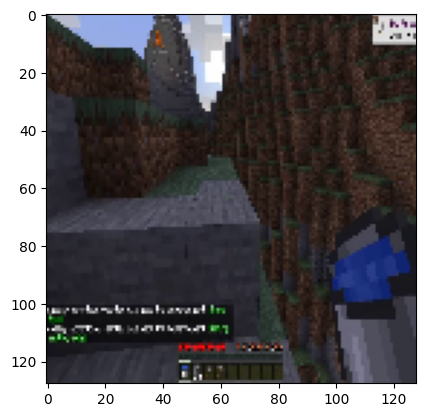

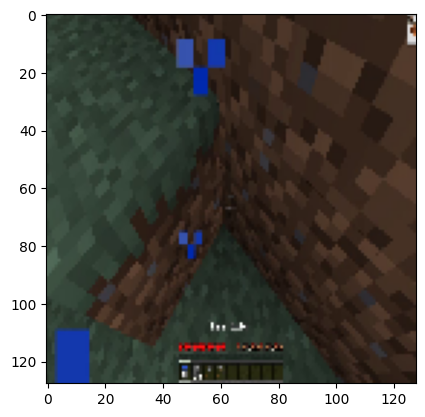

133.54199


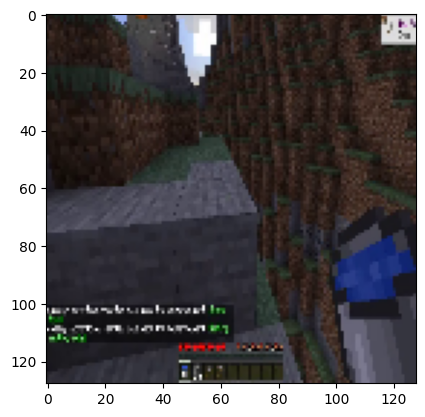

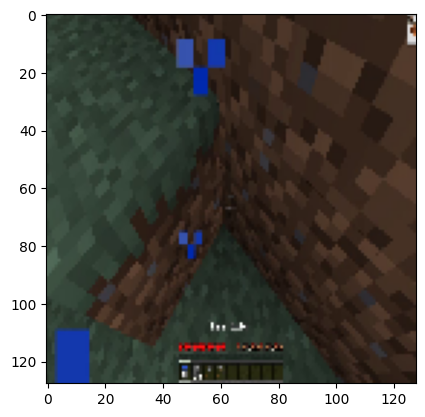

In [13]:
for obs in demonstrations[0]['video'][123:125]:
    result, query_obs_vec = retriever.retrieve(obs)
    print(result['distance'])
    plt.imshow(obs[..., ::-1])
    plt.show()
    res_demo = load_demonstration(result['demo_id'])
    res_situation = load_situation(result['sit_frame_idx'], res_demo)
    plt.imshow(res_situation[..., ::-1])
    plt.show()

In [20]:
from scipy.spatial.distance import euclidean

In [18]:
def l2_distance(a, b):
    return euclidean(a, b) ** 2

In [125]:
l2_distance(query_obs_vec, retriever.memory.index.reconstruct(38))

261.08333681715885

In [114]:
16.15**2

260.82249999999993

In [106]:
result['distance']

261.08337

In [18]:
retriever.memory.index.reconstruct(67)

(1024,)

In [19]:
result.keys()

dict_keys(['idx', 'demo_id', 'sit_frame_idx', 'distance', 'actions'])

67

In [61]:
retriever.memory.index.reconstruct(int(result['idx']))

array([-2.8993337 , -0.21491544, -0.32291505, ..., -0.08695894,
       -0.03951202, -0.15778641], dtype=float32)

In [1]:
class REBECA(nn.Module):
    def __init__(self, encoder_model, encoder_weights, memory_path, device='auto'):
        super().__init__()

        if device == 'auto':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.retriever = Retriever(encoder_model, encoder_weights, memory_path)
        
        # Unfreeze final layers
        self.vpt = VPTEncoder(encoder_model, encoder_weights, freeze=True)
        self.trainable_parameters = []
        for param in self.vpt.policy.lastlayer.parameters():
            param.requires_grad = True
            self.trainable_parameters.append(param)

        self.controller = Controller()

    def forward(self, obs):
        # retrieve situations only if the agent diverges from the previous situation
        if self.current_situation is None:
            result, query_obs_vec = self.retriever.retrieve(obs)
            self.current_situation = result
            self.situation_counter += 1
        else:
            query_obs_vec = self.retriever.encode_query(obs)
            if l2_distance(query_obs_vec, retriever.memory.index.reconstruct(self.current_situation['idx'])) > 300 or self.situation_counter > 128:
                result, query_obs_vec = self.retriever.retrieve(query_obs_vec, encode_obs=False)
                self.current_situation = result
                self.situation_counter = 0
            else:
                self.situation_counter += 1
                result = self.current_situation

        situation = torch.Tensor(self.retriever.memory.index.reconstruct(result['idx'])).reshape(1, 1, -1)
        obs_vector, self.hidden_state = self.vpt(obs, self.hidden_state)

        retrieved_actions = {
            "camera": self._one_hot_encode(result['actions']['camera'], 121).to(self.device),
            "keyboard": self._one_hot_encode(result['actions']['buttons'], 8641).to(self.device)
        }
        
        action = self.controller(
            obs_vector.to(self.device), 
            situation.to(self.device), 
            retrieved_actions
        )

        return action

    def reset(self):
        self.hidden_state = self.vpt.policy.initial_state(1)
        self.current_situation = None
        self.situation_counter = 0
        self.retriever.reset()

    def _one_hot_encode(self, actions: list, num_classes: int, add_batch_dim: bool = True):
        '''One-hot encodes the actions'''
        actions = torch.tensor(actions)
        if add_batch_dim:
            actions = actions.unsqueeze(0)
        return torch.nn.functional.one_hot(actions, num_classes=num_classes).float()

NameError: name 'nn' is not defined

In [15]:
rebeca = REBECA(in_model, in_weights, "data/memory.json", device='cuda')
rebeca.to(rebeca.device)
...

Ellipsis

In [16]:
rebeca.reset()

In [21]:
for frame in demonstrations[0]['video'][0:2]:
    actions = rebeca(frame)

In [23]:
actions[0]

tensor([[-0.0514, -0.1729,  0.2063,  ...,  0.0101, -0.1178, -0.0225]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)